# Transfering Lane Detection Learning To Steering With CNN - Experiment 1 #

In this experiment we performed transfer learning from a lane detection CNN model to learning steering. 

Created: Tue Mar  9 23:07:04 2021

Last modified:

@author: 
Kevin Machado Gamboa

CE903 - Group Project Team 6

University of Essex




## References:
    
1. 

##  Libraries

In [1]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

**IF GPU Available** - Configuring Tensorflow GPU

In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Flatten

1 Physical GPUs, 1 Logical GPUs


Developed Functions

In [3]:
def plot_steering(x):
    
    fig, ax = plt.subplots(figsize=(15,3))
    # adding circunference
    ax.plot(np.linspace(-1,1,50), np.sqrt(1 - np.linspace(-1,1,50)**2))
    # adding steering value
    ax.scatter(x, np.sqrt(1-x**2), c='r', s= 300, marker="o", alpha=0.5)
    
    ax.axvline(ls='--',c='grey', lw=1)
    
    ax.set(title= 'Steering Output Visualization', xlabel= 'normaliza values')
    ax.annotate('Right', xy=(0.2, 0.4), fontsize=50)
    ax.annotate('Left', xy=(-0.5, 0.4), fontsize=50)
    
    fig.show()

def transform_im(im, newsize):
    small_img = cv.resize(im, newsize)
    small_img = np.array(small_img)
    small_img = small_img[None, :, :, :]
    return(small_img)

def normalize(x, mi, ma):
    return (x-mi)/(ma-mi)

def re_scale(x, mi, ma):
    return x * (ma-mi) + mi

## Data Loading

In [4]:
# Loading Labels
data_ann_path = '../../../data'
data_out = pd.read_csv(data_ann_path + '/_controls.csv')
y = data_out.steer

# Loading Images
im_path = os.path.abspath('..\..\..\data\lane_detection')
im_files = os.listdir(im_path)
#newsize = (300, 300)
newsize = (160, 80)
X = []
for idx, name in tqdm(enumerate(im_files)):
    #X.append(cv.resize(cv.imread(os.path.join(im_path, name)), newsize, interpolation = cv.INTER_AREA)/127.5-1.0)
    X.append(cv.normalize(cv.resize(cv.imread(os.path.join(im_path, name)), newsize),
             None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F))
#   im_dataset_pil.append(Image.open(os.path.join(im_path, name)))
#   X.append(np.array(im_dataset_pil[idx].resize(newsize))/127.5-1.0)

255it [00:18, 13.72it/s]


### Data split

In [5]:
X = np.array(X)
mi, ma = min(y), max(y)
y = normalize(np.array(y),mi,ma)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [6]:
print('Shape of training dataset:', np.shape(X_train))

Shape of training dataset: (204, 80, 160, 3)


In [7]:
# X_train = np.expand_dims(X_train, axis=0)
# X_val = np.expand_dims(X_val, axis=0)

In [8]:
input_shape = tf.keras.layers.Input(shape=X_train[0].shape)
print('Input shape:', input_shape)

Input shape: KerasTensor(type_spec=TensorSpec(shape=(None, 80, 160, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


### Steering Visualization

C:\Users\kevin\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


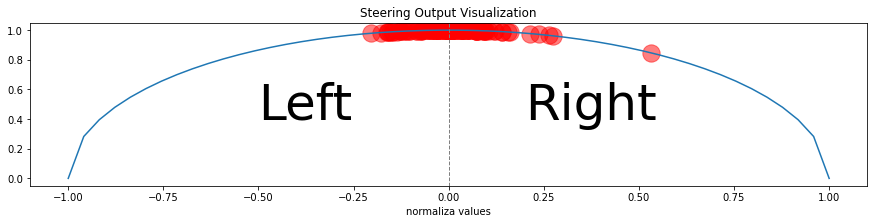

In [9]:
plot_steering(re_scale(y, mi, ma))

## Loading the Model

In [10]:
lane_model = load_model('NEW_full_CNN_model.h5')
model_insize = lane_model.input_shape
print('model input shape:', model_insize)
# --------------------------
lane_model.summary()

#tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

model input shape: (None, 80, 160, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 78, 158, 8)        224       
_________________________________________________________________
Conv2 (Conv2D)               (None, 76, 156, 16)       1168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 38, 78, 16)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 36, 76, 16)        2320      
_________________________________________________________________
dropout (Dropout)            (None, 36, 76, 16)        0         
_________________________________________________________________
Conv4 (Conv2D)               (None, 34, 74, 32)        4640      
_________________________________________________________________
dropout_1 (Dropout

First, lets **FREEZE ALL the parameters from this model**. We can type `lane_model.summary()` and verify that the number of trainable parameters is equal to zero at this point.

In [11]:
lane_model.trainable = False

#### Adding classification layers to the model
To do this we can create a new model, then add the lane_model and create the rest of the architecture for our steering prediction

In [23]:
steering_model = tf.keras.Sequential([
    lane_model,
    Flatten(),
    Dense(100, activation='elu'),
    Dense(50, activation='elu'),
    Dense(10, activation='elu'),
    Dense(1)
])

steering_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 80, 160, 1)        181681    
_________________________________________________________________
flatten_2 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               1280100   
_________________________________________________________________
dense_7 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 1,467,352
Trainable params: 1,285,671
Non-trainable params: 181,681
______________________________________

Now, lets define the rest of the model parameters and Train our model

In [24]:
# Model Parameters
optimus = tf.keras.optimizers.Adam(lr=1.0e-5)
steering_model.compile(optimizer=optimus,
                       loss='mean_squared_error')
# Tensorflow Callbacks
checkpoint_path = 'saved_model/'
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path+'model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')

batch = 50

In [25]:
history_1 = steering_model.fit(X_train, y_train, epochs=600, batch_size=50, validation_data=(X_val, y_val), callbacks = [early_stop, checkpoint])

Epoch 1/600
5/5 [==============================] - 5s 346ms/step - loss: 0.0549 - val_loss: 0.0577
Epoch 2/600
5/5 [==============================] - 1s 139ms/step - loss: 0.0436 - val_loss: 0.0462
Epoch 3/600
5/5 [==============================] - 1s 142ms/step - loss: 0.0283 - val_loss: 0.0371
Epoch 4/600
5/5 [==============================] - 1s 137ms/step - loss: 0.0241 - val_loss: 0.0305
Epoch 5/600
5/5 [==============================] - 1s 134ms/step - loss: 0.0218 - val_loss: 0.0261
Epoch 6/600
5/5 [==============================] - 1s 135ms/step - loss: 0.0159 - val_loss: 0.0232
Epoch 7/600
5/5 [==============================] - 1s 133ms/step - loss: 0.0146 - val_loss: 0.0215
Epoch 8/600
5/5 [==============================] - 1s 134ms/step - loss: 0.0129 - val_loss: 0.0204
Epoch 9/600
5/5 [==============================] - 1s 135ms/step - loss: 0.0133 - val_loss: 0.0192
Epoch 10/600
5/5 [==============================] - 1s 147ms/step - loss: 0.0118 - val_loss: 0.0184
Epoch 11/

In [28]:
steering_model.save('steering_tf_lanes_model.h5')

## Model Results


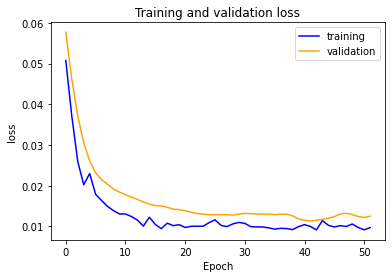

In [26]:
# acc_2 = history_2.history['accuracy']
# val_acc_2 = history_2.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
epochs = range(len(loss))

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, color='blue', label='training')
plt.plot(epochs, val_loss, color='orange', label='validation')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()

C:\Users\kevin\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


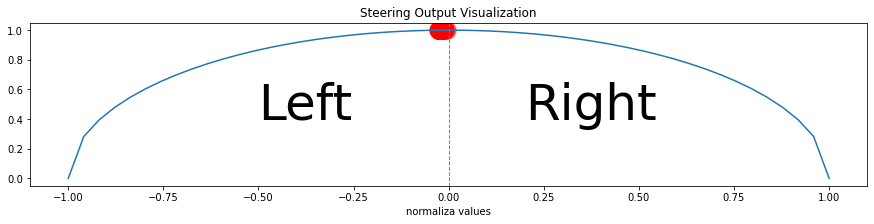

In [27]:
plot_steering(re_scale(steering_model.predict(X), mi, ma))

## Model Implementation

The first step for implementing this model in the Carla Simulator is to load the model

In [1]:
model_path = 'saved_model/model-008-0.01.h5'
nvidia_steering_model = tf.keras.models.load_model(model_path)

NameError: name 'tf' is not defined